In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torchvision
import torchvision.transforms as T
import gc
from IPython.display import clear_output

In [237]:
filenames = [name for name in os.listdir("./test")]

In [238]:
maxnum = 27

data = torch.zeros((maxnum, 3, 227, 227))

for idx, i in enumerate(filenames):
  if idx == maxnum: break
  if i[-3:] == 'jpg':
    image = torchvision.io.read_image("./test/"+i)

    data[idx] = T.Resize((227, 227))(image)

    if idx%500 == 0:
      print(f"loaded {(idx/maxnum)*100}%")


loaded 0.0%


In [239]:
data = data/255
data = data.resize(maxnum, 3, 227, 227)

C:\Users\Klayton Smith\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [240]:
filenames = [name for name in os.listdir("./test_masks")]

In [241]:
maxnum = 27

masks = torch.zeros((maxnum, 3, 227, 227))

for idx, i in enumerate(filenames):
  if idx == maxnum: break
  if i[-3:] == 'png':
    image = torchvision.io.read_image("./test_masks/"+i)

    masks[idx] = T.Resize((227, 227))(image)

    if idx%100 == 0:
      print(f"loaded {(idx/maxnum)*100}%")


loaded 0.0%


In [242]:
masks = (masks*100).clamp(max = 1)

In [243]:
class ContextEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c2d1 = nn.Conv2d(3, 96, 11, stride=4)
        self.relu1 = nn.LeakyReLU()
        self.mp1 = nn.MaxPool2d(3, 2)
        self.c2d2 = nn.Conv2d(96, 256, 5, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.mp2 = nn.MaxPool2d(3, 2)
        self.c2d3 = nn.Conv2d(256, 384, 3, padding=1)
        self.relu3 = nn.LeakyReLU()
        self.c2d4 = nn.Conv2d(384, 384, 3, padding=1)
        self.relu4 = nn.LeakyReLU()
        self.c2d5 = nn.Conv2d(384, 256, 3, padding=1)
        self.relu5 = nn.LeakyReLU()
        self.mp3 = nn.MaxPool2d(3,2)

        self.cwfc = nn.ConvTranspose2d(256, 256, 1, stride=1,groups=256)

        self.uc1 = nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2)
        self.uc2 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2)
        self.uc3 = nn.ConvTranspose2d(64, 64, 5, stride=2, padding=2)
        self.uc4 = nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2)
        self.uc5 = nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2)
        self.resize = torchvision.transforms.Resize((227,227))

    def anet(self, img):
        res = img

        res = self.c2d1(res)
        res = self.relu1(res)
        res = self.mp1(res)
        res = self.c2d2(res)
        res = self.relu2(res)
        res = self.mp2(res)
        res = self.c2d3(res)
        res = self.relu3(res)
        res = self.c2d4(res)
        res = self.relu4(res)
        res = self.c2d5(res)
        res = self.relu5(res)
        res = self.mp3(res)

        return res
    def dec(self, dat):
        res = dat

        res = self.uc1(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc2(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc3(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc4(res)
        res = torch.nn.functional.leaky_relu(res)
        res = self.uc5(res)
        res = torch.nn.functional.tanh(res)
        res = self.resize(res)

        return res

    def forward(self, img):
        res = img

        res = self.anet(res)
        res = self.cwfc(res)
        res = self.dec(res)

        return res


# I'll try using this but the paper says they couldn't get it to converge so we'll see what happens
class Adversarial(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4)
        self.conv2 = nn.Conv2d(64, 128, 4)
        self.conv3 = nn.Conv2d(128, 256, 4)
        self.conv4 = nn.Conv2d(256, 512, 4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(100352, 2)


    def forward(self, img):
        res = img
        res = self.conv1(res)
        res = self.conv2(res)
        res = self.conv3(res)
        res = self.conv4(res)
        res = self.flatten(res)
        res = self.linear(res)
        return res
        


In [244]:
losses = []

In [245]:

model = ContextEncoder()
model.to(device)

loss_fun = torch.nn.MSELoss()

batch = (data - masks).clamp(max=1, min=0)
batchres = (data - torchvision.transforms.functional.invert(masks)).clamp(max=1, min=0)
masks = masks.to(device)

batch = batch.to(device)
batchres = batchres.to(device)

f = open("./loss_data.csv", "w")
f.write("epoch, loss\n")

12

epoch #4570
loss: 0.0002950021007563919


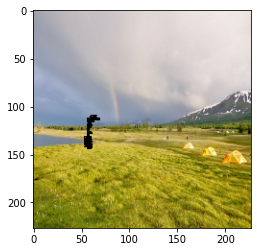

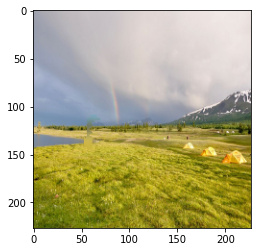

In [246]:
for i in range(10, 4571, 10):

  try:
    del model_save
  except:
    pass

  with torch.no_grad():

    model_save = torch.load(f"./model_saves/{i}.pt")

    model.load_state_dict(model_save)

    torch.cuda.empty_cache()
    gc.collect()

    reconstructed_images = model(batch)

    reconstructed_images -= T.functional.invert(masks)*100

    reconstructed_images = reconstructed_images.clamp(max=1, min=0)

    loss = loss_fun(reconstructed_images, batchres)

    losses.append(loss)

    clear_output()
    print(f"epoch #{i}")
    print(f"loss: {loss}")

    f.write(f"{i},{loss}\n")

    plt.imshow(batch[0].cpu().permute(1,2,0).detach().numpy())
    plt.show()
    plt.imshow(((model.forward(batch[0]).cpu()- torchvision.transforms.functional.invert(masks[0].cpu())).clamp(max=1, min=0)+batch[0].cpu()).reshape(3,227,227).permute(1,2,0).detach().numpy())
    plt.show()

f.close()
